# Tutorial 5

In [1]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from dump_cells import dump

# Lab 31.03.2022
## Task 1

In [9]:
k_rep = 5E+1
k_atr = 1
dt = 1E-2
alpha = 0.1
kd = 1E-1
ka = 1E-2
L = 25
R = np.random.normal(1.0, 1E-1)

In [2]:
class CellClass:
    x = 0
    y = 0
    pos = [x, y]
    c_id = 0
    c_family = 0
    kd = 0
    ka = 0
    R = 0
    c_type = "benign"
    time = 0
    F = [0, 0]
    close_neighbors_num = 0
    dividing = -1
    covered = False
    global L
    global k_rep
    global k_atr
    global dt
    global alpha
    def __init__(self, x, y, c_id, c_family, kd, ka, R, c_type="benign", time=0):
        self.x = x
        self.y = y
        self.pos = [x, y]
        self.c_id = c_id
        self.c_family = c_family
        self.kd = kd
        self.ka = ka
        self.R = R
        self.c_type = c_type
        self.time = time
        
    def apply_periodic(self):
        x, y = self.pos
        if x < 0:
            x = -x
        elif x > L:
            x = L-x 
        if y < 0:
            y = -y
        elif y > L:
            y = L-y
        self.pos = [x, y]
            
    def closest_image(self,x2):
        x12 = np.subtract(x2, self.pos)
        if x12[0] > L / 2:
            x12[0] = x12[0] - L
        elif x12[0] < -L / 2:
            x12[0] = x12[0] + L
        if x12[1] > L / 2:
            x12[1] = x12[1] - L
        elif x12[1] < -L / 2:
            x12[1] = x12[1] + L
        return x12
    def calc_dist(self, other):
        rij = self.closest_image(other.pos)
        rij_val = np.linalg.norm(rij)
        rij = rij/rij_val
        return rij, rij_val

    def cell_divide(self, new_id):
        #use the position of the mother plus random to create the daugther
        new_pos = self.pos + (1e-1)*np.random.rand(2)
        #select a new radius with a normal distribution for both daugther and mother
        new_radii = np.random.normal(1.0, 1e-1)
        self.R = np.random.normal(1.0, 1e-1)
        # create a new cell
        new_cell = CellClass(x=new_pos[0],
                             y=new_pos[1],
                             c_id=new_id,
                             kd=self.kd,
                             ka=self.ka,
                             R=new_radii,
                             c_type=self.c_type,
                             c_family=self.c_id)
        #apply periodic boundaries to the new daughter in case that the cell is at the edge
        new_cell.apply_periodic()

        #reset the time in each cell
        new_cell.time = 0.0
        self.time = 0.0
        # Update dividing status
        self.dividing = 1
        new_cell.dividing = 1
        #link the two cells, you will need to implement something like that
        # to know what force calculate
        self.c_family = new_cell.c_id
        #return the new cell
        return new_cell

    def checkDivided(self, cell_b):
        if self.c_family != cell_b.c_id:
            return
        else:
            trigerring_distance = self.R + cell_b.R
            dire_w, dire_len = self.calc_dist(cell_b)
            if trigerring_distance*0.98<=dire_len:
                self.dividing = -1
                cell_b.dividing = -1

    def isDivided(self, part_list):
        for part in part_list:
            self.checkDivided(part)

    def isNeighbor(self, cell_b):
        if self != cell_b and cell_b.dividing != 1:
            trigerring_distance = self.R + cell_b.R
            dire_w, dire_len = self.calc_dist(cell_b)
            if trigerring_distance*1.1>=dire_len:
                return 1
            else:
                return 0
        else:
            return 0

    def get_close_neighbors_num(self, part_list):
        self.close_neighbors_num = np.sum([self.isNeighbor(part) for part in part_list])

    def get_single_force(self,cell_b):
        # Implement here the system of calculating forces between daughter and child
        if self.c_family != cell_b.c_id or self.c_family == -1:
            mult = 1
        else:
            mult = 0.5
        if self != cell_b:
            trigerring_distance = self.R + cell_b.R
            dire_w, dire_len = self.calc_dist(cell_b)
            if trigerring_distance*1.1>=dire_len:
                if trigerring_distance>=dire_len:
                    return -mult*k_rep*(trigerring_distance-dire_len)*dire_w
                else:
                    return k_atr*dire_w
        return np.array([0,0])
    def isCovered(self, part_list):
        for cell_b in part_list:
            if self != cell_b and cell_b.dividing != 1:
                trigerring_distance = self.R + cell_b.R
                dire_w, dire_len = self.calc_dist(cell_b)
                if trigerring_distance*0.98>dire_len:
                    self.covered = True
                    return
                else:
                    self.covered = False


    def get_forces(self, part_list):
        self.F = [self.get_single_force(part) for part in part_list]
        self.F = np.sum(self.F, axis=0)
    
    def update(self, part_list):
        self.time += dt
        eta = np.random.normal(0,1, 2)
        self.isCovered(part_list)
        self.F = [0, 0]
        self.get_forces(part_list)
        self.pos = self.pos + self.F * dt + np.sqrt(alpha*dt)*eta
        self.apply_periodic()
        self.isDivided(part_list)

In [ ]:
c = CellClass(0, 0, c_id=1, c_family=-1, kd=kd, ka=ka, R=0.3)
d = CellClass(1, 1, c_id=2, c_family=-1, kd=kd, ka=ka, R=0.3)
e = CellClass(1.002, 1, c_id=3, c_family=-1, kd=kd, ka=ka, R=0.3)
f = CellClass(1.5, 1, c_id=4, c_family=-1, kd=kd, ka=ka, R=0.3)
part_list = [c,d,e,f]

In [ ]:
d.get_close_neighbors_num(part_list)

In [ ]:
d.close_neighbors_num

In [ ]:
g = d.cell_divide(5)

In [ ]:
d.c_family

In [ ]:
c.get_forces(part_list)
print(c.F)

In [ ]:
print(c.pos, c.F)
c.update(part_list)
print(c.pos, c.F)

In [10]:
%%time

Nsnaps = 100 # Number of Pictures
Nrun = 100 # Run Steps until a picture is taken 100-1000
Cell_Processes_Check = 30  # how often we check if the cell can
# divide or died. Note we don’t have to check each time step.
# The rates k_d and k_a then change to k_a(t) = cell.time*k_a.
# Same for k_d(t) = cell.time*k_d.
# Here cell.time is the time that a given cell has been alive
# Each process is trigger at random so if ran() < k_a(t) then the cell died, same for k_d

cell_num = []
t_tab = []

# c = CellClass(1.1, 2.1, c_id=-1, c_family=-1, kd=kd, ka=ka, R=0.3)
# d = CellClass(1, 1.2, c_id=-1, c_family=-1, kd=kd, ka=ka, R=0.3)
# e = CellClass(3, 1.3, c_id=-1, c_family=-1, kd=kd, ka=ka, R=0.3)
# f = CellClass(1.5, 1.12, c_id=-1, c_family=-1, kd=kd, ka=ka, R=0.3)
# part_list = [c,d,e,f]

adam = CellClass(10.01, 10.01, c_id=1, c_family=-1, kd=kd, ka=ka, R=0.8)
part_list = [adam]

for snap in range(Nsnaps):
    force = [part.F for part in part_list]
    R = [part.R for part in part_list]
    r = [part.pos for part in part_list]
    dump('t={}'.format(snap), r, R, force, L, plot_forces=False)
    for run in range(1, Nrun+1):
        for part in part_list:
            part.update(part_list)

        if (snap*Nrun+run) % Cell_Processes_Check == 0:
            #Check for cell division
            new_id = len(part_list)+1
            for part in part_list:
                if part.kd < np.random.rand() and part.dividing != 1 and part.covered == False:
                    new_cell = part.cell_divide(new_id)
                    new_id += 1
                    part.get_close_neighbors_num(part_list)
                    part.kd = part.kd*(1.0-part.close_neighbors_num/6)
                    # part.kd = part.time * part.kd
                    part_list.append(new_cell)
        if (snap*Nrun+run) % Cell_Processes_Check == 5 and len(part_list) != 1:
            #Check for cell dead
            for part in part_list:
                if part.ka < np.random.rand() and part.dividing != 1:
                    part_list.remove(part)
                    part.ka = part.time * part.ka
        cell_num.append(len(part_list))
        t_tab.append((snap*Nrun+run)*dt)

/var/folders/4f/nc8733x97cnbfw1jfx_t9mfm0000gn/T/ipykernel_41694/2277039366.py:59: RuntimeWarning: invalid value encountered in true_divide
  rij = rij/rij_val


CPU times: user 21.4 s, sys: 3.25 s, total: 24.6 s
Wall time: 10 s


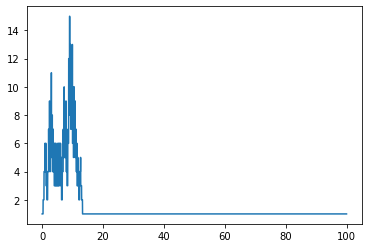

In [11]:
plt.plot(t_tab, cell_num)

## Cell death at the same time as division

In [12]:
k_rep = 5E+1
k_atr = 1
dt = 1E-2
alpha = 0.1
kd = 1E-1
ka = 1E-3
L = 25
R = np.random.normal(1.0, 1E-1)
Nsnaps = 25 # Number of Pictures
Nrun = 200 # Run Steps until a picture is taken 100-1000
Cell_Processes_Check = 20  # how often we check if the cell can
# divide or died. Note we don’t have to check each time step.
# The rates k_d and k_a then change to k_a(t) = cell.time*k_a.
# Same for k_d(t) = cell.time*k_d.
# Here cell.time is the time that a given cell has been alive
# Each process is trigger at random so if ran() < k_a(t) then the cell died, same for k_d

In [13]:
%%time
cell_num_sim = []
t_tab_sim = []

adam = CellClass(10.01, 10.01, c_id=1, c_family=-1, kd=kd, ka=ka, R=0.8)
part_list = [adam]

for snap in range(Nsnaps):
    force = [part.F for part in part_list]
    R = [part.R for part in part_list]
    r = [part.pos for part in part_list]
    dump('t={}'.format(snap), r, R, force, L, plot_forces=False)
    for run in range(1, Nrun+1):
        for part in part_list:
            part.update(part_list)

        if (snap*Nrun+run) % Cell_Processes_Check == 0:
            #Check for cell division
            new_id = len(part_list)+1
            for part in part_list:
                if part.kd < np.random.rand() and part.dividing != 1 and part.covered == False:
                    new_cell = part.cell_divide(new_id)
                    new_id += 1
                    part.get_close_neighbors_num(part_list)
                    part.kd = part.kd*(1.0-part.close_neighbors_num/6)
                    # part.kd = part.time * part.kd
                    part_list.append(new_cell)
            #Check for cell dead
            for part in part_list:
                if part.ka < np.random.rand() and part.dividing != 1:
                    part_list.remove(part)
                    part.ka = part.time * part.ka
        cell_num_sim.append(len(part_list))
        t_tab_sim.append((snap*Nrun+run)*dt)

/var/folders/4f/nc8733x97cnbfw1jfx_t9mfm0000gn/T/ipykernel_41694/2277039366.py:59: RuntimeWarning: invalid value encountered in true_divide
  rij = rij/rij_val


CPU times: user 12min 15s, sys: 3.02 s, total: 12min 18s
Wall time: 12min 8s


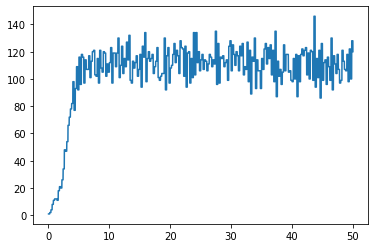

In [14]:
plt.plot(t_tab_sim, cell_num_sim)

Increased $k_d$

In [15]:
ka = 1E-2

In [32]:
%%time

cell_num_sim_2 = []
t_tab_sim_2 = []

adam = CellClass(10.01, 10.01, c_id=1, c_family=-1, kd=kd, ka=ka, R=0.8)
part_list = [adam]

for snap in range(Nsnaps):
    force = [part.F for part in part_list]
    R = [part.R for part in part_list]
    r = [part.pos for part in part_list]
    dump('t={}'.format(snap), r, R, force, L, plot_forces=False)
    for run in range(1, Nrun+1):
        for part in part_list:
            part.update(part_list)

        if (snap*Nrun+run) % Cell_Processes_Check == 0:
            #Check for cell division
            new_id = len(part_list)+1
            for part in part_list:
                if part.kd < np.random.rand() and part.dividing != 1 and part.covered == False:
                    new_cell = part.cell_divide(new_id)
                    new_id += 1
                    part.get_close_neighbors_num(part_list)
                    part.kd = part.kd*(1.0-part.close_neighbors_num/6)
                    # part.kd = part.time * part.kd
                    part_list.append(new_cell)
            #Check for cell dead
            for part in part_list:
                if part.ka < np.random.rand() and part.dividing != 1:
                    part_list.remove(part)
                    part.ka = part.time * part.ka
        cell_num_sim_2.append(len(part_list))
        t_tab_sim_2.append((snap*Nrun+run)*dt)

/var/folders/4f/nc8733x97cnbfw1jfx_t9mfm0000gn/T/ipykernel_41694/2277039366.py:59: RuntimeWarning: invalid value encountered in true_divide
  rij = rij/rij_val


CPU times: user 13min 24s, sys: 3.31 s, total: 13min 27s
Wall time: 13min 22s


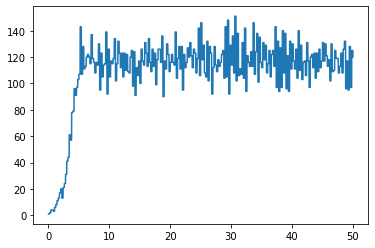

In [33]:
plt.plot(t_tab_sim_2, cell_num_sim_2)

Increased $k_d$

In [34]:
ka = 1E-1

In [35]:
%%time

cell_num_sim_3 = []
t_tab_sim_3 = []


adam = CellClass(10.01, 10.01, c_id=1, c_family=-1, kd=kd, ka=ka, R=0.8)
part_list = [adam]

for snap in range(Nsnaps):
    force = [part.F for part in part_list]
    R = [part.R for part in part_list]
    r = [part.pos for part in part_list]
    dump('t={}'.format(snap), r, R, force, L, plot_forces=False)
    for run in range(1, Nrun+1):
        for part in part_list:
            part.update(part_list)

        if (snap*Nrun+run) % Cell_Processes_Check == 0:
            #Check for cell division
            new_id = len(part_list)+1
            for part in part_list:
                if part.kd < np.random.rand() and part.dividing != 1 and part.covered == False:
                    new_cell = part.cell_divide(new_id)
                    new_id += 1
                    part.get_close_neighbors_num(part_list)
                    part.kd = part.kd*(1.0-part.close_neighbors_num/6)
                    # part.kd = part.time * part.kd
                    part_list.append(new_cell)
            #Check for cell dead
            for part in part_list:
                if part.ka < np.random.rand() and part.dividing != 1:
                    part_list.remove(part)
                    part.ka = part.time * part.ka
        cell_num_sim_3.append(len(part_list))
        t_tab_sim_3.append((snap*Nrun+run)*dt)

/var/folders/4f/nc8733x97cnbfw1jfx_t9mfm0000gn/T/ipykernel_41694/2277039366.py:59: RuntimeWarning: invalid value encountered in true_divide
  rij = rij/rij_val


CPU times: user 13min 12s, sys: 3.81 s, total: 13min 16s
Wall time: 13min 9s


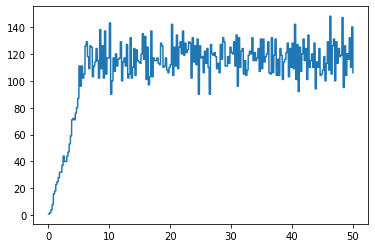

In [36]:
plt.plot(t_tab_sim_3, cell_num_sim_3)

Summary

Summary

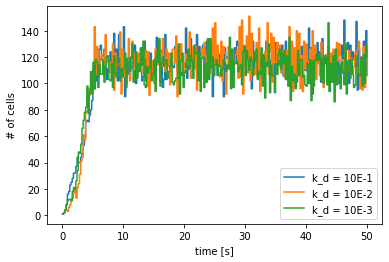

In [37]:
# with plt.xkcd():
plt.plot(t_tab_sim_3, cell_num_sim_3, label="k_d = 10E-1")
plt.plot(t_tab_sim_2, cell_num_sim_2, label="k_d = 10E-2")
plt.plot(t_tab_sim, cell_num_sim, label="k_d = 10E-3")
plt.ylabel("# of cells")
plt.xlabel("time [s]")
plt.legend()

# Now once again, with different condition for reproduction

In [38]:
k_rep = 5E+1
k_atr = 1
dt = 1E-2
alpha = 0.1
kd = 1E-1
ka = 1E-3
L = 25
R = np.random.normal(1.0, 1E-1)
Nsnaps = 25 # Number of Pictures
Nrun = 200 # Run Steps until a picture is taken 100-1000
Cell_Processes_Check = 20  # how often we check if the cell can
# divide or died. Note we don’t have to check each time step.
# The rates k_d and k_a then change to k_a(t) = cell.time*k_a.
# Same for k_d(t) = cell.time*k_d.
# Here cell.time is the time that a given cell has been alive
# Each process is trigger at random so if ran() < k_a(t) then the cell died, same for k_d

In [39]:
%%time

cell_num_sim_alt = []
t_tab_sim_alt = []

adam = CellClass(10.01, 10.01, c_id=1, c_family=-1, kd=kd, ka=ka, R=0.8)
part_list = [adam]

for snap in range(Nsnaps):
    force = [part.F for part in part_list]
    R = [part.R for part in part_list]
    r = [part.pos for part in part_list]
    dump('t={}'.format(snap), r, R, force, L, plot_forces=False)
    for run in range(1, Nrun+1):
        for part in part_list:
            part.update(part_list)

        if (snap*Nrun+run) % Cell_Processes_Check == 0:
            #Check for cell division
            new_id = len(part_list)+1
            for part in part_list:
                if part.kd < np.random.rand() and part.dividing != 1 and part.covered == False:
                    new_cell = part.cell_divide(new_id)
                    new_id += 1
                    # part.get_close_neighbors_num(part_list)
                    # part.kd = part.kd*(1.0-part.close_neighbors_num/6)
                    part.kd = part.time * part.kd
                    part_list.append(new_cell)
            #Check for cell dead
            for part in part_list:
                if part.ka < np.random.rand() and part.dividing != 1:
                    part_list.remove(part)
                    part.ka = part.time * part.ka
        cell_num_sim_alt.append(len(part_list))
        t_tab_sim_alt.append((snap*Nrun+run)*dt)

/var/folders/4f/nc8733x97cnbfw1jfx_t9mfm0000gn/T/ipykernel_41694/2277039366.py:59: RuntimeWarning: invalid value encountered in true_divide
  rij = rij/rij_val


CPU times: user 12min 38s, sys: 6.05 s, total: 12min 44s
Wall time: 13min 46s


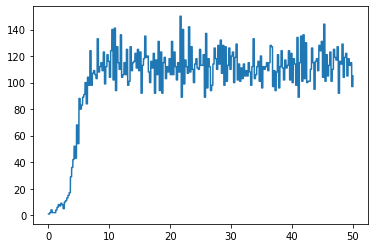

In [40]:
plt.plot(t_tab_sim_alt, cell_num_sim_alt)

Increased $k_d$

In [41]:
ka = 1E-2

In [42]:
%%time

cell_num_sim_alt_2 = []
t_tab_sim_alt_2 = []


adam = CellClass(10.01, 10.01, c_id=1, c_family=-1, kd=kd, ka=ka, R=0.8)
part_list = [adam]

for snap in range(Nsnaps):
    force = [part.F for part in part_list]
    R = [part.R for part in part_list]
    r = [part.pos for part in part_list]
    dump('t={}'.format(snap), r, R, force, L, plot_forces=False)
    for run in range(1, Nrun+1):
        for part in part_list:
            part.update(part_list)

        if (snap*Nrun+run) % Cell_Processes_Check == 0:
            #Check for cell division
            new_id = len(part_list)+1
            for part in part_list:
                if part.kd < np.random.rand() and part.dividing != 1 and part.covered == False:
                    new_cell = part.cell_divide(new_id)
                    new_id += 1
                    # part.get_close_neighbors_num(part_list)
                    # part.kd = part.kd*(1.0-part.close_neighbors_num/6)
                    part.kd = part.time * part.kd
                    part_list.append(new_cell)
            #Check for cell dead
            for part in part_list:
                if part.ka < np.random.rand() and part.dividing != 1:
                    part_list.remove(part)
                    part.ka = part.time * part.ka
        cell_num_sim_alt_2.append(len(part_list))
        t_tab_sim_alt_2.append((snap*Nrun+run)*dt)

/var/folders/4f/nc8733x97cnbfw1jfx_t9mfm0000gn/T/ipykernel_41694/2277039366.py:59: RuntimeWarning: invalid value encountered in true_divide
  rij = rij/rij_val


CPU times: user 12min 57s, sys: 6.26 s, total: 13min 4s
Wall time: 14min 11s


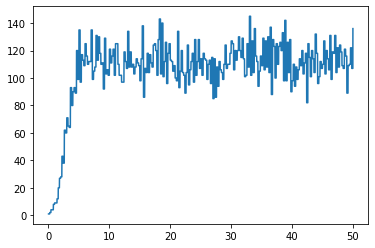

In [43]:
plt.plot(t_tab_sim_alt_2, cell_num_sim_alt_2)

Increased $k_d$

In [44]:
ka = 1E-1

In [45]:
%%time

cell_num_sim_alt_3 = []
t_tab_sim_alt_3 = []

adam = CellClass(10.01, 10.01, c_id=1, c_family=-1, kd=kd, ka=ka, R=0.8)
part_list = [adam]

for snap in range(Nsnaps):
    force = [part.F for part in part_list]
    R = [part.R for part in part_list]
    r = [part.pos for part in part_list]
    dump('t={}'.format(snap), r, R, force, L, plot_forces=False)
    for run in range(1, Nrun+1):
        for part in part_list:
            part.update(part_list)

        if (snap*Nrun+run) % Cell_Processes_Check == 0:
            #Check for cell division
            new_id = len(part_list)+1
            for part in part_list:
                if part.kd < np.random.rand() and part.dividing != 1 and part.covered == False:
                    new_cell = part.cell_divide(new_id)
                    new_id += 1
                    # part.get_close_neighbors_num(part_list)
                    # part.kd = part.kd*(1.0-part.close_neighbors_num/6)
                    part.kd = part.time * part.kd
                    part_list.append(new_cell)
            #Check for cell dead
            for part in part_list:
                if part.ka < np.random.rand() and part.dividing != 1:
                    part_list.remove(part)
                    part.ka = part.time * part.ka
        cell_num_sim_alt_3.append(len(part_list))
        t_tab_sim_alt_3.append((snap*Nrun+run)*dt)

/var/folders/4f/nc8733x97cnbfw1jfx_t9mfm0000gn/T/ipykernel_41694/2277039366.py:59: RuntimeWarning: invalid value encountered in true_divide
  rij = rij/rij_val


CPU times: user 13min 12s, sys: 4.06 s, total: 13min 16s
Wall time: 13min 14s


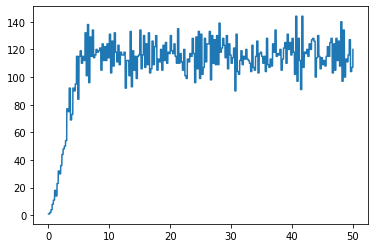

In [46]:
plt.plot(t_tab_sim_alt_3, cell_num_sim_alt_3)

Summary

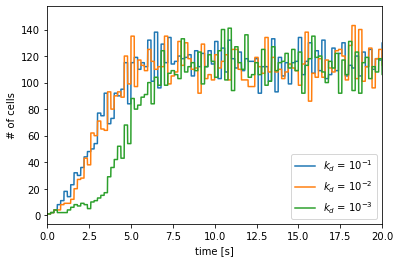

In [60]:
# with plt.xkcd():
plt.plot(t_tab_sim_alt_3, cell_num_sim_alt_3, label="$k_d$ = $10^{-1}$")
plt.plot(t_tab_sim_alt_2, cell_num_sim_alt_2, label="$k_d$ = $10^{-2}$")
plt.plot(t_tab_sim_alt, cell_num_sim_alt, label="$k_d$ = $10^{-3}$")
plt.ylabel("# of cells")
plt.xlabel("time [s]")
plt.xlim(0, 20)
plt.legend()